In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 20

In [3]:
y1_step = .02
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [4]:
def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-10] = 1e-10
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [5]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 0.001, 2000, 0.05)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 2000: PDE Error: 0.106157056012; False Transient Error: 0.106148777678; Iterations: 153; CG Error: 0.000000000093
Episode 2000: PDE Error: 0.106158344426; False Transient Error: 0.106150108930; Iterations: 153; CG Error: 0.000000000098
Episode 2000: PDE Error: 0.106151574448; False Transient Error: 0.106143511164; Iterations: 156; CG Error: 0.000000000091
Episode 2000: PDE Error: 0.106157539866; False Transient Error: 0.106149279536; Iterations: 153; CG Error: 0.000000000095
Episode 2000: PDE Error: 0.106156728958; False Transient Error: 0.106148452475; Iterations: 153; CG Error: 0.000000000092
Episode 2000: PDE Error: 0.106157477411; False Transient Error: 0.106149466411; Iterations: 154; CG Error: 0.000000000096
Episode 2000: PDE Error: 0.106155183127; False Transient Error: 0.106146908227; Iterations: 153; CG Error: 0.000000000089
Episode 2000: PDE Error: 0.106154413400; False Transient Error: 0.106146136432; Iterations: 152; CG Error: 0.000000000099
Episode 2000: PDE Error:

In [6]:
np.save(f"v_list_{λ}", ϕ_list)
np.save(f"e_list_{λ}", ems_list)

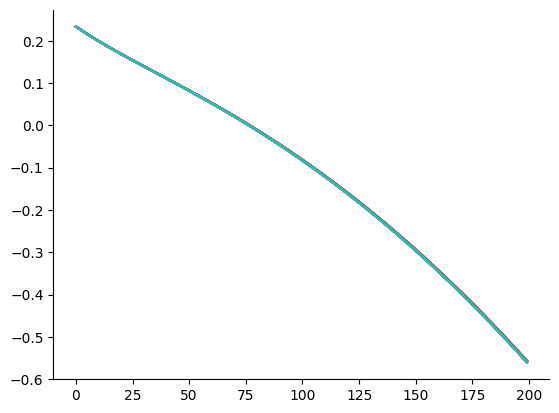

In [7]:
plt.plot(ϕ_list[0])
plt.show()

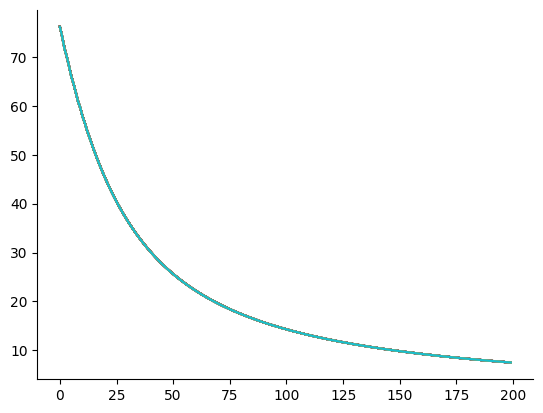

In [8]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [9]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1.
ϵ = 0.001
max_iter = 5000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.01 + ems_old * 0.99
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.065287753869	 rhs error: 0.064231566270
Episode: 2	 lhs error: 0.064608296117	 rhs error: 0.067403942815
Episode: 3	 lhs error: 0.073177720100	 rhs error: 0.076024863923
Episode: 4	 lhs error: 0.079189868664	 rhs error: 0.082064526616
Episode: 5	 lhs error: 0.083669831404	 rhs error: 0.086567160168
Episode: 6	 lhs error: 0.087147189140	 rhs error: 0.090054185321
Episode: 7	 lhs error: 0.089915991277	 rhs error: 0.092823529376
Episode: 8	 lhs error: 0.092156647545	 rhs error: 0.095061460678
Episode: 9	 lhs error: 0.093979757874	 rhs error: 0.096892187123
Episode: 10	 lhs error: 0.095453655936	 rhs error: 0.098402738676
Episode: 11	 lhs error: 0.096630085202	 rhs error: 0.099656545767
Episode: 12	 lhs error: 0.097570873712	 rhs error: 0.100701247120
Episode: 13	 lhs error: 0.098365819240	 rhs error: 0.101573284034
Episode: 14	 lhs error: 0.099122500881	 rhs error: 0.102300658701
Episode: 15	 lhs error: 0.099916880452	 rhs error: 0.102904831218
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.106874333003	 rhs error: 0.112265865052
Episode: 126	 lhs error: 0.106867847856	 rhs error: 0.112116072319
Episode: 127	 lhs error: 0.106859653502	 rhs error: 0.111960721108
Episode: 128	 lhs error: 0.106849842884	 rhs error: 0.111799397870
Episode: 129	 lhs error: 0.111187944964	 rhs error: 0.111631710268
Episode: 130	 lhs error: 0.111090473605	 rhs error: 0.118883051875
Episode: 131	 lhs error: 0.110010951348	 rhs error: 0.118773846347
Episode: 132	 lhs error: 0.109580622849	 rhs error: 0.113332825907
Episode: 133	 lhs error: 0.111805487685	 rhs error: 0.114796583096
Episode: 134	 lhs error: 0.111643451603	 rhs error: 0.119645558153
Episode: 135	 lhs error: 0.110590593830	 rhs error: 0.116456685859
Episode: 136	 lhs error: 0.111366879700	 rhs error: 0.117444565979
Episode: 137	 lhs error: 0.110482249061	 rhs error: 0.118347532376
Episode: 138	 lhs error: 0.110013656441	 rhs error: 0.114816293618
Episode: 139	 lhs error: 0.110943091310	 rhs error: 0.11619717

Episode: 248	 lhs error: 0.105055951458	 rhs error: 0.124798081708
Episode: 249	 lhs error: 0.104342965123	 rhs error: 0.123607437621
Episode: 250	 lhs error: 0.104288880047	 rhs error: 0.123057232583
Episode: 251	 lhs error: 0.104382912849	 rhs error: 0.122172490848
Episode: 252	 lhs error: 0.104580988091	 rhs error: 0.121911628095
Episode: 253	 lhs error: 0.104317949109	 rhs error: 0.121780650546
Episode: 254	 lhs error: 0.104306507614	 rhs error: 0.121119750387
Episode: 255	 lhs error: 0.104354616111	 rhs error: 0.120484736824
Episode: 256	 lhs error: 0.104339814711	 rhs error: 0.120098889706
Episode: 257	 lhs error: 0.104288099187	 rhs error: 0.119670088424
Episode: 258	 lhs error: 0.104278724910	 rhs error: 0.119207489206
Episode: 259	 lhs error: 0.104275510761	 rhs error: 0.118825520863
Episode: 260	 lhs error: 0.104263573372	 rhs error: 0.118480116858
Episode: 261	 lhs error: 0.104252386307	 rhs error: 0.118248815952
Episode: 262	 lhs error: 0.104241550719	 rhs error: 0.11817690

Episode: 371	 lhs error: 0.116331412802	 rhs error: 0.131787854355
Episode: 372	 lhs error: 0.111095526668	 rhs error: 0.117214144967
Episode: 373	 lhs error: 0.112752377976	 rhs error: 0.165348646459
Episode: 374	 lhs error: 0.108653576550	 rhs error: 0.123349675430
Episode: 375	 lhs error: 0.107514214703	 rhs error: 0.112490960220
Episode: 376	 lhs error: 0.104955620862	 rhs error: 0.119769885087
Episode: 377	 lhs error: 0.105069923763	 rhs error: 0.113599354902
Episode: 378	 lhs error: 0.105036859939	 rhs error: 0.118917575998
Episode: 379	 lhs error: 0.104124644793	 rhs error: 0.114590271379
Episode: 380	 lhs error: 0.103909442566	 rhs error: 0.115461964284
Episode: 381	 lhs error: 0.103835155477	 rhs error: 0.115131240655
Episode: 382	 lhs error: 0.103799897175	 rhs error: 0.115134186332
Episode: 383	 lhs error: 0.103666683228	 rhs error: 0.115262535687
Episode: 384	 lhs error: 0.103869540972	 rhs error: 0.115271250989
Episode: 385	 lhs error: 0.103941179726	 rhs error: 0.11524416

Episode: 494	 lhs error: 0.102537841254	 rhs error: 0.112649474663
Episode: 495	 lhs error: 0.102532045829	 rhs error: 0.112629460202
Episode: 496	 lhs error: 0.102526204424	 rhs error: 0.112606986095
Episode: 497	 lhs error: 0.102520320967	 rhs error: 0.112582088537
Episode: 498	 lhs error: 0.102514395390	 rhs error: 0.112554817126
Episode: 499	 lhs error: 0.102508426773	 rhs error: 0.112525222284
Episode: 500	 lhs error: 0.102502414749	 rhs error: 0.112493353616
Episode: 501	 lhs error: 0.102496359495	 rhs error: 0.112459260991
Episode: 502	 lhs error: 0.102490261652	 rhs error: 0.112422994734
Episode: 503	 lhs error: 0.102484122240	 rhs error: 0.112384605306
Episode: 504	 lhs error: 0.102477942484	 rhs error: 0.112344143106
Episode: 505	 lhs error: 0.102471723653	 rhs error: 0.112301658403
Episode: 506	 lhs error: 0.102465466981	 rhs error: 0.112257201305
Episode: 507	 lhs error: 0.102459173643	 rhs error: 0.112210821737
Episode: 508	 lhs error: 0.102452844754	 rhs error: 0.11216256

Episode: 617	 lhs error: 0.104437433883	 rhs error: 0.131071463661
Episode: 618	 lhs error: 0.103333226449	 rhs error: 0.119769379937
Episode: 619	 lhs error: 0.103633007551	 rhs error: 0.128688466708
Episode: 620	 lhs error: 0.102501236518	 rhs error: 0.122443847060
Episode: 621	 lhs error: 0.102113149695	 rhs error: 0.123893961567
Episode: 622	 lhs error: 0.102248072879	 rhs error: 0.123754086239
Episode: 623	 lhs error: 0.102257207657	 rhs error: 0.121069175100
Episode: 624	 lhs error: 0.102317496570	 rhs error: 0.122911757254
Episode: 625	 lhs error: 0.102092173102	 rhs error: 0.120256497135
Episode: 626	 lhs error: 0.102039924609	 rhs error: 0.121150018038
Episode: 627	 lhs error: 0.102046144584	 rhs error: 0.120621301320
Episode: 628	 lhs error: 0.101978509157	 rhs error: 0.121223099159
Episode: 629	 lhs error: 0.102048403235	 rhs error: 0.121492513766
Episode: 630	 lhs error: 0.102045408118	 rhs error: 0.121626144154
Episode: 631	 lhs error: 0.102074270903	 rhs error: 0.12210101

Episode: 740	 lhs error: 0.100719077308	 rhs error: 0.203134765400
Episode: 741	 lhs error: 0.100579774345	 rhs error: 0.202077253013
Episode: 742	 lhs error: 0.100627970911	 rhs error: 0.202094312443
Episode: 743	 lhs error: 0.100585779126	 rhs error: 0.199387015935
Episode: 744	 lhs error: 0.100560454196	 rhs error: 0.198003023122
Episode: 745	 lhs error: 0.100548180985	 rhs error: 0.195667936901
Episode: 746	 lhs error: 0.100519648584	 rhs error: 0.193076670345
Episode: 747	 lhs error: 0.100500423372	 rhs error: 0.190334281812
Episode: 748	 lhs error: 0.100478266054	 rhs error: 0.187180141484
Episode: 749	 lhs error: 0.100455417258	 rhs error: 0.183804237577
Episode: 750	 lhs error: 0.100433346046	 rhs error: 0.180161120379
Episode: 751	 lhs error: 0.100410372121	 rhs error: 0.176272250373
Episode: 752	 lhs error: 0.100387311646	 rhs error: 0.172177374011
Episode: 753	 lhs error: 0.100364114032	 rhs error: 0.167899857090
Episode: 754	 lhs error: 0.100340845944	 rhs error: 0.16348080

Episode: 863	 lhs error: 0.099111622218	 rhs error: 0.115042745560
Episode: 864	 lhs error: 0.099220509425	 rhs error: 0.114491044220
Episode: 865	 lhs error: 0.099347840396	 rhs error: 0.113610470068
Episode: 866	 lhs error: 0.099464980367	 rhs error: 0.112394679288
Episode: 867	 lhs error: 0.099532447678	 rhs error: 0.111276795368
Episode: 868	 lhs error: 0.099523351704	 rhs error: 0.110106811066
Episode: 869	 lhs error: 0.099451988909	 rhs error: 0.109173072273
Episode: 870	 lhs error: 0.099370314742	 rhs error: 0.109238519405
Episode: 871	 lhs error: 0.099323219371	 rhs error: 0.109266346333
Episode: 872	 lhs error: 0.099316472779	 rhs error: 0.109261966494
Episode: 873	 lhs error: 0.099330944512	 rhs error: 0.109233384031
Episode: 874	 lhs error: 0.099348715674	 rhs error: 0.109187151086
Episode: 875	 lhs error: 0.099361917288	 rhs error: 0.109128805774
Episode: 876	 lhs error: 0.099369606405	 rhs error: 0.109063081184
Episode: 877	 lhs error: 0.099373322735	 rhs error: 0.10899341

Episode: 986	 lhs error: 0.099187129518	 rhs error: 0.105821352944
Episode: 987	 lhs error: 0.099180875488	 rhs error: 0.105788678803
Episode: 988	 lhs error: 0.099174796542	 rhs error: 0.105750769515
Episode: 989	 lhs error: 0.099169070743	 rhs error: 0.105708082041
Episode: 990	 lhs error: 0.099163762581	 rhs error: 0.105661174650
Episode: 991	 lhs error: 0.099158849223	 rhs error: 0.105610546151
Episode: 992	 lhs error: 0.099154224632	 rhs error: 0.105556594574
Episode: 993	 lhs error: 0.099149759545	 rhs error: 0.105499636163
Episode: 994	 lhs error: 0.099145336425	 rhs error: 0.105439916515
Episode: 995	 lhs error: 0.099140851255	 rhs error: 0.105377636402
Episode: 996	 lhs error: 0.099136227322	 rhs error: 0.105312978644
Episode: 997	 lhs error: 0.099131421270	 rhs error: 0.105246114266
Episode: 998	 lhs error: 0.099126413731	 rhs error: 0.105177205467
Episode: 999	 lhs error: 0.099121205027	 rhs error: 0.105106410637
Episode: 1000	 lhs error: 0.099115812163	 rhs error: 0.1050338

Episode: 1107	 lhs error: 0.105802038231	 rhs error: 0.109524887905
Episode: 1108	 lhs error: 0.111994998754	 rhs error: 0.151781842150
Episode: 1109	 lhs error: 0.102353036066	 rhs error: 0.115951551233
Episode: 1110	 lhs error: 0.103148037579	 rhs error: 0.108922599387
Episode: 1111	 lhs error: 0.111398937197	 rhs error: 0.116839875625
Episode: 1112	 lhs error: 0.115822009115	 rhs error: 0.147792156034
Episode: 1113	 lhs error: 0.103765641860	 rhs error: 0.114790785302
Episode: 1114	 lhs error: 0.107064822106	 rhs error: 0.105182499320
Episode: 1115	 lhs error: 0.113748859258	 rhs error: 0.125687597047
Episode: 1116	 lhs error: 0.110648213216	 rhs error: 0.132425759642
Episode: 1117	 lhs error: 0.119154028174	 rhs error: 0.152904032571
Episode: 1118	 lhs error: 0.102569830854	 rhs error: 0.113284647683
Episode: 1119	 lhs error: 0.105335552127	 rhs error: 0.103510869463
Episode: 1120	 lhs error: 0.111133297821	 rhs error: 0.131380922218
Episode: 1121	 lhs error: 0.102725347173	 rhs er

Episode: 1228	 lhs error: 0.100300454150	 rhs error: 0.105596023233
Episode: 1229	 lhs error: 0.098324466893	 rhs error: 0.110662246935
Episode: 1230	 lhs error: 0.098281393099	 rhs error: 0.110167877854
Episode: 1231	 lhs error: 0.098175355055	 rhs error: 0.110075463603
Episode: 1232	 lhs error: 0.098154973575	 rhs error: 0.109938427195
Episode: 1233	 lhs error: 0.098133431754	 rhs error: 0.109795930648
Episode: 1234	 lhs error: 0.098117234382	 rhs error: 0.109644424956
Episode: 1235	 lhs error: 0.098107746485	 rhs error: 0.109486388241
Episode: 1236	 lhs error: 0.098102229226	 rhs error: 0.109322888481
Episode: 1237	 lhs error: 0.098098645997	 rhs error: 0.109154181264
Episode: 1238	 lhs error: 0.098095918381	 rhs error: 0.108980108483
Episode: 1239	 lhs error: 0.098093565436	 rhs error: 0.108800436201
Episode: 1240	 lhs error: 0.098091392312	 rhs error: 0.108614957683
Episode: 1241	 lhs error: 0.098089325341	 rhs error: 0.108423503986
Episode: 1242	 lhs error: 0.098087337352	 rhs er

Episode: 1349	 lhs error: 0.116201641374	 rhs error: 0.131285787804
Episode: 1350	 lhs error: 0.106262680139	 rhs error: 0.132698488977
Episode: 1351	 lhs error: 0.109017578633	 rhs error: 0.102107803123
Episode: 1352	 lhs error: 0.117450117967	 rhs error: 0.129738762352
Episode: 1353	 lhs error: 0.103343313179	 rhs error: 0.140098711857
Episode: 1354	 lhs error: 0.113961656100	 rhs error: 0.103049197247
Episode: 1355	 lhs error: 0.118807244568	 rhs error: 0.131716446557
Episode: 1356	 lhs error: 0.105311500396	 rhs error: 0.141223113077
Episode: 1357	 lhs error: 0.117766043320	 rhs error: 0.105523926001
Episode: 1358	 lhs error: 0.120448671562	 rhs error: 0.133616430106
Episode: 1359	 lhs error: 0.101938017182	 rhs error: 0.138692344837
Episode: 1360	 lhs error: 0.109965724416	 rhs error: 0.101600978247
Episode: 1361	 lhs error: 0.117439576757	 rhs error: 0.128633427037
Episode: 1362	 lhs error: 0.101573449757	 rhs error: 0.136810066154
Episode: 1363	 lhs error: 0.109384045803	 rhs er

Episode: 1470	 lhs error: 0.097362965603	 rhs error: 0.121818855231
Episode: 1471	 lhs error: 0.097382584218	 rhs error: 0.123295202925
Episode: 1472	 lhs error: 0.097412446661	 rhs error: 0.125048782286
Episode: 1473	 lhs error: 0.097461665103	 rhs error: 0.127211830128
Episode: 1474	 lhs error: 0.097557834838	 rhs error: 0.130064398179
Episode: 1475	 lhs error: 0.097854941235	 rhs error: 0.134461650474
Episode: 1476	 lhs error: 0.098800471872	 rhs error: 0.140145743075
Episode: 1477	 lhs error: 0.099727614333	 rhs error: 0.134398250755
Episode: 1478	 lhs error: 0.106296170363	 rhs error: 0.157005326859
Episode: 1479	 lhs error: 0.099316284142	 rhs error: 0.118198668982
Episode: 1480	 lhs error: 0.097278824480	 rhs error: 0.102025923614
Episode: 1481	 lhs error: 0.097105566833	 rhs error: 0.098214034324
Episode: 1482	 lhs error: 0.097052002080	 rhs error: 0.098189339580
Episode: 1483	 lhs error: 0.097094091102	 rhs error: 0.098181054213
Episode: 1484	 lhs error: 0.097040176259	 rhs er

Episode: 1591	 lhs error: 0.107451150593	 rhs error: 0.120379418934
Episode: 1592	 lhs error: 0.111648386546	 rhs error: 0.177428486191
Episode: 1593	 lhs error: 0.110608677642	 rhs error: 0.130354551042
Episode: 1594	 lhs error: 0.134621150669	 rhs error: 0.142565193060
Episode: 1595	 lhs error: 0.105359619162	 rhs error: 0.129506827918
Episode: 1596	 lhs error: 0.104669602619	 rhs error: 0.122023316352
Episode: 1597	 lhs error: 0.108631440503	 rhs error: 0.139479611278
Episode: 1598	 lhs error: 0.099980178214	 rhs error: 0.123320438948
Episode: 1599	 lhs error: 0.109268840611	 rhs error: 0.163486238245
Episode: 1600	 lhs error: 0.110406289791	 rhs error: 0.121117474097
Episode: 1601	 lhs error: 0.114849076951	 rhs error: 0.171203571749
Episode: 1602	 lhs error: 0.107545621832	 rhs error: 0.127280660391
Episode: 1603	 lhs error: 0.125044083204	 rhs error: 0.175810172734
Episode: 1604	 lhs error: 0.106432945266	 rhs error: 0.140545847375
Episode: 1605	 lhs error: 0.103703046024	 rhs er

Episode: 1712	 lhs error: 0.095589080606	 rhs error: 0.111663268677
Episode: 1713	 lhs error: 0.095583520315	 rhs error: 0.111586511567
Episode: 1714	 lhs error: 0.095578028049	 rhs error: 0.111511042398
Episode: 1715	 lhs error: 0.095572605429	 rhs error: 0.111436834369
Episode: 1716	 lhs error: 0.095567254237	 rhs error: 0.111363860505
Episode: 1717	 lhs error: 0.095561976375	 rhs error: 0.111292093609
Episode: 1718	 lhs error: 0.113609225120	 rhs error: 0.111221482111
Episode: 1719	 lhs error: 0.109621296191	 rhs error: 0.163931516452
Episode: 1720	 lhs error: 0.097572932268	 rhs error: 0.111948727010
Episode: 1721	 lhs error: 0.113343280148	 rhs error: 0.112206577737
Episode: 1722	 lhs error: 0.110670190943	 rhs error: 0.165166625218
Episode: 1723	 lhs error: 0.097461429179	 rhs error: 0.111589418373
Episode: 1724	 lhs error: 0.114144597710	 rhs error: 0.111860707074
Episode: 1725	 lhs error: 0.111393193907	 rhs error: 0.167497201218
Episode: 1726	 lhs error: 0.097319769144	 rhs er

Episode: 1833	 lhs error: 0.095527748270	 rhs error: 0.105404635801
Episode: 1834	 lhs error: 0.095515354522	 rhs error: 0.105191339983
Episode: 1835	 lhs error: 0.095502868810	 rhs error: 0.104976711588
Episode: 1836	 lhs error: 0.095493072054	 rhs error: 0.104760609906
Episode: 1837	 lhs error: 0.095485880172	 rhs error: 0.104542824837
Episode: 1838	 lhs error: 0.095479428053	 rhs error: 0.104323033918
Episode: 1839	 lhs error: 0.095473921515	 rhs error: 0.104100740336
Episode: 1840	 lhs error: 0.095469643249	 rhs error: 0.103875229222
Episode: 1841	 lhs error: 0.095467003898	 rhs error: 0.103645505082
Episode: 1842	 lhs error: 0.095466630093	 rhs error: 0.103410184659
Episode: 1843	 lhs error: 0.095469523594	 rhs error: 0.103167319094
Episode: 1844	 lhs error: 0.095477375754	 rhs error: 0.102929061304
Episode: 1845	 lhs error: 0.095493246520	 rhs error: 0.104252642465
Episode: 1846	 lhs error: 0.095523202892	 rhs error: 0.105808174512
Episode: 1847	 lhs error: 0.095580932656	 rhs er

Episode: 1954	 lhs error: 0.095233341535	 rhs error: 0.195370031853
Episode: 1955	 lhs error: 0.095146603708	 rhs error: 0.192464839767
Episode: 1956	 lhs error: 0.095286628777	 rhs error: 0.191349747581
Episode: 1957	 lhs error: 0.095168666932	 rhs error: 0.189051293358
Episode: 1958	 lhs error: 0.095177655004	 rhs error: 0.187104154856
Episode: 1959	 lhs error: 0.095200058685	 rhs error: 0.185506989953
Episode: 1960	 lhs error: 0.095153423438	 rhs error: 0.183548182567
Episode: 1961	 lhs error: 0.095160635095	 rhs error: 0.181849965069
Episode: 1962	 lhs error: 0.095152553719	 rhs error: 0.180190137862
Episode: 1963	 lhs error: 0.095133765212	 rhs error: 0.178475409198
Episode: 1964	 lhs error: 0.095130547850	 rhs error: 0.176879316218
Episode: 1965	 lhs error: 0.095119170786	 rhs error: 0.175294265117
Episode: 1966	 lhs error: 0.095107795118	 rhs error: 0.173730222238
Episode: 1967	 lhs error: 0.095099799176	 rhs error: 0.172221888270
Episode: 1968	 lhs error: 0.095089131107	 rhs er

Episode: 2075	 lhs error: 0.093913136407	 rhs error: 0.190241145105
Episode: 2076	 lhs error: 0.093907566988	 rhs error: 0.188959565033
Episode: 2077	 lhs error: 0.093902534085	 rhs error: 0.187652633012
Episode: 2078	 lhs error: 0.093897523706	 rhs error: 0.186321044226
Episode: 2079	 lhs error: 0.093892537850	 rhs error: 0.184965351690
Episode: 2080	 lhs error: 0.093887575711	 rhs error: 0.183586234883
Episode: 2081	 lhs error: 0.093882635903	 rhs error: 0.182184433304
Episode: 2082	 lhs error: 0.093877719909	 rhs error: 0.180760547772
Episode: 2083	 lhs error: 0.093872828572	 rhs error: 0.179315194424
Episode: 2084	 lhs error: 0.093867960621	 rhs error: 0.177849099198
Episode: 2085	 lhs error: 0.093863116336	 rhs error: 0.176362917722
Episode: 2086	 lhs error: 0.093858297243	 rhs error: 0.174857239350
Episode: 2087	 lhs error: 0.093853503110	 rhs error: 0.173332739550
Episode: 2088	 lhs error: 0.093848733445	 rhs error: 0.171790104434
Episode: 2089	 lhs error: 0.093843989408	 rhs er

Episode: 2196	 lhs error: 0.092974865639	 rhs error: 0.118084292122
Episode: 2197	 lhs error: 0.093116823117	 rhs error: 0.117973389858
Episode: 2198	 lhs error: 0.092781484509	 rhs error: 0.117136682073
Episode: 2199	 lhs error: 0.093005162577	 rhs error: 0.118129241855
Episode: 2200	 lhs error: 0.093207081497	 rhs error: 0.118069972166
Episode: 2201	 lhs error: 0.092986699845	 rhs error: 0.117202207880
Episode: 2202	 lhs error: 0.092945237131	 rhs error: 0.117856984680
Episode: 2203	 lhs error: 0.093013383448	 rhs error: 0.118095185342
Episode: 2204	 lhs error: 0.093059868641	 rhs error: 0.117326445262
Episode: 2205	 lhs error: 0.093001320026	 rhs error: 0.117488593157
Episode: 2206	 lhs error: 0.093016094815	 rhs error: 0.117776947015
Episode: 2207	 lhs error: 0.093092998108	 rhs error: 0.117309500372
Episode: 2208	 lhs error: 0.093061213408	 rhs error: 0.117183750839
Episode: 2209	 lhs error: 0.092932445663	 rhs error: 0.117282633770
Episode: 2210	 lhs error: 0.092987245037	 rhs er

Episode: 2317	 lhs error: 0.093690389521	 rhs error: 0.112919253135
Episode: 2318	 lhs error: 0.093963714502	 rhs error: 0.112623555867
Episode: 2319	 lhs error: 0.093927144833	 rhs error: 0.112184670742
Episode: 2320	 lhs error: 0.093716044708	 rhs error: 0.111870431282
Episode: 2321	 lhs error: 0.093806344826	 rhs error: 0.111519283207
Episode: 2322	 lhs error: 0.093880893280	 rhs error: 0.111093513917
Episode: 2323	 lhs error: 0.093765824161	 rhs error: 0.110711561842
Episode: 2324	 lhs error: 0.093756640505	 rhs error: 0.110322010318
Episode: 2325	 lhs error: 0.093788691558	 rhs error: 0.109908320355
Episode: 2326	 lhs error: 0.093748183311	 rhs error: 0.109500750450
Episode: 2327	 lhs error: 0.093715664960	 rhs error: 0.109098729082
Episode: 2328	 lhs error: 0.093708688035	 rhs error: 0.108697001437
Episode: 2329	 lhs error: 0.093688064098	 rhs error: 0.108299266265
Episode: 2330	 lhs error: 0.093658584713	 rhs error: 0.107911393661
Episode: 2331	 lhs error: 0.093635949668	 rhs er

Episode: 2438	 lhs error: 0.092310756884	 rhs error: 3.392569495081
Episode: 2439	 lhs error: 0.092283854859	 rhs error: 3.374321414500
Episode: 2440	 lhs error: 0.092267456588	 rhs error: 3.345222603740
Episode: 2441	 lhs error: 0.092251167220	 rhs error: 3.333057020394
Episode: 2442	 lhs error: 0.092235196661	 rhs error: 3.313372535402
Episode: 2443	 lhs error: 0.092219114522	 rhs error: 3.305698481140
Episode: 2444	 lhs error: 0.092203246718	 rhs error: 3.292454944673
Episode: 2445	 lhs error: 0.092187269642	 rhs error: 3.288093198956
Episode: 2446	 lhs error: 0.092171421065	 rhs error: 3.279392749597
Episode: 2447	 lhs error: 0.092155407698	 rhs error: 3.277419829801
Episode: 2448	 lhs error: 0.092139473567	 rhs error: 3.271943196669
Episode: 2449	 lhs error: 0.092123331773	 rhs error: 3.271665526030
Episode: 2450	 lhs error: 0.092107227717	 rhs error: 3.268479317588
Episode: 2451	 lhs error: 0.092090874241	 rhs error: 3.269363386905
Episode: 2452	 lhs error: 0.092074526881	 rhs er

Episode: 2559	 lhs error: 0.091076439932	 rhs error: 0.294370700374
Episode: 2560	 lhs error: 0.091114323027	 rhs error: 0.292078728408
Episode: 2561	 lhs error: 0.091124375446	 rhs error: 0.291711815433
Episode: 2562	 lhs error: 0.091117209377	 rhs error: 0.285181924425
Episode: 2563	 lhs error: 0.091118568655	 rhs error: 0.273248048434
Episode: 2564	 lhs error: 0.091097539745	 rhs error: 0.260216312480
Episode: 2565	 lhs error: 0.091069996989	 rhs error: 0.248599153349
Episode: 2566	 lhs error: 0.091043903141	 rhs error: 0.238715305572
Episode: 2567	 lhs error: 0.091021206542	 rhs error: 0.230066024975
Episode: 2568	 lhs error: 0.091003581238	 rhs error: 0.222169838034
Episode: 2569	 lhs error: 0.090991132112	 rhs error: 0.214743145083
Episode: 2570	 lhs error: 0.090979518682	 rhs error: 0.207642835836
Episode: 2571	 lhs error: 0.090968570110	 rhs error: 0.200794757830
Episode: 2572	 lhs error: 0.090958170473	 rhs error: 0.194155367404
Episode: 2573	 lhs error: 0.090948251497	 rhs er

Episode: 2680	 lhs error: 0.091711963398	 rhs error: 0.116100666639
Episode: 2681	 lhs error: 0.091712495332	 rhs error: 0.115902545808
Episode: 2682	 lhs error: 0.091712837913	 rhs error: 0.115705582914
Episode: 2683	 lhs error: 0.091712986533	 rhs error: 0.115509828488
Episode: 2684	 lhs error: 0.091712925144	 rhs error: 0.115315315407
Episode: 2685	 lhs error: 0.091712590113	 rhs error: 0.115122027605
Episode: 2686	 lhs error: 0.091711492833	 rhs error: 0.114929740883
Episode: 2687	 lhs error: 0.091711937097	 rhs error: 0.114736020231
Episode: 2688	 lhs error: 0.091720120344	 rhs error: 0.114563663425
Episode: 2689	 lhs error: 0.091704161700	 rhs error: 0.114362632757
Episode: 2690	 lhs error: 0.091710579703	 rhs error: 0.114181719205
Episode: 2691	 lhs error: 0.091707155016	 rhs error: 0.113995911545
Episode: 2692	 lhs error: 0.091706786135	 rhs error: 0.113814298680
Episode: 2693	 lhs error: 0.091705043782	 rhs error: 0.113633516051
Episode: 2694	 lhs error: 0.091703517986	 rhs er

Episode: 2801	 lhs error: 0.090799442690	 rhs error: 0.126416845044
Episode: 2802	 lhs error: 0.090796389797	 rhs error: 0.126549535288
Episode: 2803	 lhs error: 0.090793018625	 rhs error: 0.126654263794
Episode: 2804	 lhs error: 0.090789304341	 rhs error: 0.126728715479
Episode: 2805	 lhs error: 0.090791090933	 rhs error: 0.126770314969
Episode: 2806	 lhs error: 0.090794244954	 rhs error: 0.126776222485
Episode: 2807	 lhs error: 0.090797805501	 rhs error: 0.126743336818
Episode: 2808	 lhs error: 0.090801809657	 rhs error: 0.126668307832
Episode: 2809	 lhs error: 0.090806291578	 rhs error: 0.126547561018
Episode: 2810	 lhs error: 0.090811280386	 rhs error: 0.126377337057
Episode: 2811	 lhs error: 0.090816797640	 rhs error: 0.126153749389
Episode: 2812	 lhs error: 0.126325744113	 rhs error: 0.125873115506
Episode: 2813	 lhs error: 0.130981793754	 rhs error: 0.164071293620
Episode: 2814	 lhs error: 0.102599357211	 rhs error: 0.218789677232
Episode: 2815	 lhs error: 0.115547495510	 rhs er

Episode: 2922	 lhs error: 0.102957025078	 rhs error: 0.630870953514
Episode: 2923	 lhs error: 0.097656404137	 rhs error: 0.427743464906
Episode: 2924	 lhs error: 0.093901438074	 rhs error: 0.599066487136
Episode: 2925	 lhs error: 0.120821940710	 rhs error: 0.700299919991
Episode: 2926	 lhs error: 0.107126724625	 rhs error: 0.101915137380
Episode: 2927	 lhs error: 0.101904588518	 rhs error: 0.296101995153
Episode: 2928	 lhs error: 0.095707964285	 rhs error: 0.620288221274
Episode: 2929	 lhs error: 0.093156025118	 rhs error: 0.727908676686
Episode: 2930	 lhs error: 0.091702265473	 rhs error: 0.727995617457
Episode: 2931	 lhs error: 0.092787021431	 rhs error: 0.690325295710
Episode: 2932	 lhs error: 0.093056528899	 rhs error: 0.631573758426
Episode: 2933	 lhs error: 0.092866589923	 rhs error: 0.567535670426
Episode: 2934	 lhs error: 0.092490969585	 rhs error: 0.506740003132
Episode: 2935	 lhs error: 0.092100156908	 rhs error: 0.452776863308
Episode: 2936	 lhs error: 0.091767326885	 rhs er

Episode: 3043	 lhs error: 0.089805381623	 rhs error: 0.286103945848
Episode: 3044	 lhs error: 0.089802254430	 rhs error: 0.280880551947
Episode: 3045	 lhs error: 0.089799158292	 rhs error: 0.275675055473
Episode: 3046	 lhs error: 0.089796194384	 rhs error: 0.270490292631
Episode: 3047	 lhs error: 0.089793364412	 rhs error: 0.265325146473
Episode: 3048	 lhs error: 0.089790601889	 rhs error: 0.260180085791
Episode: 3049	 lhs error: 0.089787974957	 rhs error: 0.255056551057
Episode: 3050	 lhs error: 0.089785475187	 rhs error: 0.249953680614
Episode: 3051	 lhs error: 0.089783072440	 rhs error: 0.244871739411
Episode: 3052	 lhs error: 0.089780810209	 rhs error: 0.239811197267
Episode: 3053	 lhs error: 0.089778680713	 rhs error: 0.234771248796
Episode: 3054	 lhs error: 0.089776674812	 rhs error: 0.229751753059
Episode: 3055	 lhs error: 0.089774820623	 rhs error: 0.224752443462
Episode: 3056	 lhs error: 0.089773115908	 rhs error: 0.219772345432
Episode: 3057	 lhs error: 0.089771564078	 rhs er

Episode: 3164	 lhs error: 0.113295354544	 rhs error: 0.160593486855
Episode: 3165	 lhs error: 0.094995184949	 rhs error: 0.098755063380
Episode: 3166	 lhs error: 0.112012982591	 rhs error: 0.129376239674
Episode: 3167	 lhs error: 0.098849515718	 rhs error: 0.104970218821
Episode: 3168	 lhs error: 0.122034112416	 rhs error: 0.199274384843
Episode: 3169	 lhs error: 0.100561739926	 rhs error: 0.106488970649
Episode: 3170	 lhs error: 0.115596438128	 rhs error: 0.179074891691
Episode: 3171	 lhs error: 0.104344167036	 rhs error: 0.107201861311
Episode: 3172	 lhs error: 0.114362771330	 rhs error: 0.176801610485
Episode: 3173	 lhs error: 0.095103575092	 rhs error: 0.108168345931
Episode: 3174	 lhs error: 0.105975091819	 rhs error: 0.152189103763
Episode: 3175	 lhs error: 0.104481540747	 rhs error: 0.099561487360
Episode: 3176	 lhs error: 0.100172270937	 rhs error: 0.124371826934
Episode: 3177	 lhs error: 0.108256733803	 rhs error: 0.167133501282
Episode: 3178	 lhs error: 0.094522848216	 rhs er

Episode: 3285	 lhs error: 0.097328527503	 rhs error: 0.138640659126
Episode: 3286	 lhs error: 0.092624830921	 rhs error: 0.143943942680
Episode: 3287	 lhs error: 0.128378370156	 rhs error: 0.161283767486
Episode: 3288	 lhs error: 0.099938016450	 rhs error: 0.193043352719
Episode: 3289	 lhs error: 0.093496702529	 rhs error: 0.132090655716
Episode: 3290	 lhs error: 0.097209925178	 rhs error: 0.194013935204
Episode: 3291	 lhs error: 0.096351339277	 rhs error: 0.150564179877
Episode: 3292	 lhs error: 0.101597359869	 rhs error: 0.158464324432
Episode: 3293	 lhs error: 0.103054683154	 rhs error: 0.157641941429
Episode: 3294	 lhs error: 0.100118131125	 rhs error: 0.193567576710
Episode: 3295	 lhs error: 0.114323847859	 rhs error: 0.178645081218
Episode: 3296	 lhs error: 0.100722394289	 rhs error: 0.133178339959
Episode: 3297	 lhs error: 0.106273481220	 rhs error: 0.178637819543
Episode: 3298	 lhs error: 0.107410607434	 rhs error: 0.377306719573
Episode: 3299	 lhs error: 0.097910727975	 rhs er

Episode: 3406	 lhs error: 0.107412944506	 rhs error: 0.120638156942
Episode: 3407	 lhs error: 0.126807612722	 rhs error: 0.234351857091
Episode: 3408	 lhs error: 0.108677854420	 rhs error: 0.444416980921
Episode: 3409	 lhs error: 0.102562671345	 rhs error: 0.114345451732
Episode: 3410	 lhs error: 0.094082222462	 rhs error: 0.184536721157
Episode: 3411	 lhs error: 0.095901755967	 rhs error: 0.152082605917
Episode: 3412	 lhs error: 0.093335876863	 rhs error: 0.230823081034
Episode: 3413	 lhs error: 0.093351372335	 rhs error: 0.169770589870
Episode: 3414	 lhs error: 0.096148541661	 rhs error: 0.273958391654
Episode: 3415	 lhs error: 0.101102657308	 rhs error: 0.289348188566
Episode: 3416	 lhs error: 0.092130757582	 rhs error: 0.159959315506
Episode: 3417	 lhs error: 0.112373396264	 rhs error: 0.254064130153
Episode: 3418	 lhs error: 0.097179833410	 rhs error: 0.112979709601
Episode: 3419	 lhs error: 0.100206096312	 rhs error: 0.214595340378
Episode: 3420	 lhs error: 0.103941383917	 rhs er

Episode: 3527	 lhs error: 0.094929222299	 rhs error: 0.118482477273
Episode: 3528	 lhs error: 0.092640747420	 rhs error: 0.106858207432
Episode: 3529	 lhs error: 0.088989556441	 rhs error: 0.105051650016
Episode: 3530	 lhs error: 0.088947075681	 rhs error: 0.108682044788
Episode: 3531	 lhs error: 0.089000082513	 rhs error: 0.108887871651
Episode: 3532	 lhs error: 0.088956471561	 rhs error: 0.108517751623
Episode: 3533	 lhs error: 0.088956539945	 rhs error: 0.108168602185
Episode: 3534	 lhs error: 0.088975318626	 rhs error: 0.107835889642
Episode: 3535	 lhs error: 0.088980643309	 rhs error: 0.107498121271
Episode: 3536	 lhs error: 0.088985081710	 rhs error: 0.107154599290
Episode: 3537	 lhs error: 0.088990248470	 rhs error: 0.106808379649
Episode: 3538	 lhs error: 0.088996427794	 rhs error: 0.106460948192
Episode: 3539	 lhs error: 0.089004002720	 rhs error: 0.106112686861
Episode: 3540	 lhs error: 0.089013421153	 rhs error: 0.105763706010
Episode: 3541	 lhs error: 0.089025173822	 rhs er

Episode: 3648	 lhs error: 0.089116063635	 rhs error: 0.099020164809
Episode: 3649	 lhs error: 0.089846577535	 rhs error: 0.108042398448
Episode: 3650	 lhs error: 0.092487084547	 rhs error: 0.113053226391
Episode: 3651	 lhs error: 0.096170765193	 rhs error: 0.136074376411
Episode: 3652	 lhs error: 0.089220496855	 rhs error: 0.096853817102
Episode: 3653	 lhs error: 0.090097471413	 rhs error: 0.107656558577
Episode: 3654	 lhs error: 0.094486669003	 rhs error: 0.116456351040
Episode: 3655	 lhs error: 0.094029598929	 rhs error: 0.163651635235
Episode: 3656	 lhs error: 0.091030349001	 rhs error: 0.113895410733
Episode: 3657	 lhs error: 0.089349158232	 rhs error: 0.110166822536
Episode: 3658	 lhs error: 0.087357053157	 rhs error: 0.111737605095
Episode: 3659	 lhs error: 0.087357689031	 rhs error: 0.110977576228
Episode: 3660	 lhs error: 0.087462898496	 rhs error: 0.111276633746
Episode: 3661	 lhs error: 0.087422012191	 rhs error: 0.111466328979
Episode: 3662	 lhs error: 0.087367918857	 rhs er

Episode: 3769	 lhs error: 0.100138496395	 rhs error: 0.156410278208
Episode: 3770	 lhs error: 0.093117402797	 rhs error: 0.170383834884
Episode: 3771	 lhs error: 0.098157448878	 rhs error: 0.199029542019
Episode: 3772	 lhs error: 0.092180853935	 rhs error: 0.129820451850
Episode: 3773	 lhs error: 0.119036934586	 rhs error: 0.110064402757
Episode: 3774	 lhs error: 0.113962579993	 rhs error: 0.118849217521
Episode: 3775	 lhs error: 0.102629936337	 rhs error: 0.118537004454
Episode: 3776	 lhs error: 0.113996280107	 rhs error: 0.234941899431
Episode: 3777	 lhs error: 0.095040376821	 rhs error: 0.124883969724
Episode: 3778	 lhs error: 0.125184225019	 rhs error: 0.308835375435
Episode: 3779	 lhs error: 0.088441360438	 rhs error: 0.151939040595
Episode: 3780	 lhs error: 0.089444120289	 rhs error: 0.141645266590
Episode: 3781	 lhs error: 0.094785950285	 rhs error: 0.186326260169
Episode: 3782	 lhs error: 0.089450061684	 rhs error: 0.165111384184
Episode: 3783	 lhs error: 0.090034042141	 rhs er

Episode: 3890	 lhs error: 0.100356343358	 rhs error: 0.133179238832
Episode: 3891	 lhs error: 0.100088648185	 rhs error: 0.116089030281
Episode: 3892	 lhs error: 0.107158956692	 rhs error: 0.135815175020
Episode: 3893	 lhs error: 0.090584714363	 rhs error: 0.107623942572
Episode: 3894	 lhs error: 0.088904798897	 rhs error: 0.108226436233
Episode: 3895	 lhs error: 0.087717609139	 rhs error: 0.108975489915
Episode: 3896	 lhs error: 0.087076911230	 rhs error: 0.108081098149
Episode: 3897	 lhs error: 0.087196956565	 rhs error: 0.107829852476
Episode: 3898	 lhs error: 0.087170394435	 rhs error: 0.108258703750
Episode: 3899	 lhs error: 0.087146329817	 rhs error: 0.108724289845
Episode: 3900	 lhs error: 0.087143929135	 rhs error: 0.109105767358
Episode: 3901	 lhs error: 0.087149776370	 rhs error: 0.109470959650
Episode: 3902	 lhs error: 0.087155129553	 rhs error: 0.109838972531
Episode: 3903	 lhs error: 0.087158064129	 rhs error: 0.110206067361
Episode: 3904	 lhs error: 0.087159549208	 rhs er

Episode: 4011	 lhs error: 0.087016938241	 rhs error: 0.094888780563
Episode: 4012	 lhs error: 0.087013165365	 rhs error: 0.094789160874
Episode: 4013	 lhs error: 0.087009318564	 rhs error: 0.094689982057
Episode: 4014	 lhs error: 0.087005400061	 rhs error: 0.094591253872
Episode: 4015	 lhs error: 0.087001412055	 rhs error: 0.094492985740
Episode: 4016	 lhs error: 0.086997356716	 rhs error: 0.094395186755
Episode: 4017	 lhs error: 0.086993236186	 rhs error: 0.094297865678
Episode: 4018	 lhs error: 0.086989052577	 rhs error: 0.094208343122
Episode: 4019	 lhs error: 0.086984807973	 rhs error: 0.094148491111
Episode: 4020	 lhs error: 0.086980504433	 rhs error: 0.094088694549
Episode: 4021	 lhs error: 0.086976143984	 rhs error: 0.094028960560
Episode: 4022	 lhs error: 0.086971728625	 rhs error: 0.093969296155
Episode: 4023	 lhs error: 0.086967260329	 rhs error: 0.093909708239
Episode: 4024	 lhs error: 0.103791981928	 rhs error: 0.093850242536
Episode: 4025	 lhs error: 0.088780228052	 rhs er

Episode: 4132	 lhs error: 0.088516814532	 rhs error: 0.180379414108
Episode: 4133	 lhs error: 0.087894351500	 rhs error: 0.182308793936
Episode: 4134	 lhs error: 0.087239437924	 rhs error: 0.182825892808
Episode: 4135	 lhs error: 0.086714133379	 rhs error: 0.182270550889
Episode: 4136	 lhs error: 0.086498394903	 rhs error: 0.181026161534
Episode: 4137	 lhs error: 0.086336432676	 rhs error: 0.179329982626
Episode: 4138	 lhs error: 0.086269946280	 rhs error: 0.177346781792
Episode: 4139	 lhs error: 0.086269912822	 rhs error: 0.175176863300
Episode: 4140	 lhs error: 0.086284177668	 rhs error: 0.172880816015
Episode: 4141	 lhs error: 0.086308874781	 rhs error: 0.170493606188
Episode: 4142	 lhs error: 0.086340603927	 rhs error: 0.168034912041
Episode: 4143	 lhs error: 0.086376644513	 rhs error: 0.165515555634
Episode: 4144	 lhs error: 0.086414936763	 rhs error: 0.162941633250
Episode: 4145	 lhs error: 0.086453925346	 rhs error: 0.160317149292
Episode: 4146	 lhs error: 0.086492392440	 rhs er

Episode: 4253	 lhs error: 0.086849431462	 rhs error: 0.113373404929
Episode: 4254	 lhs error: 0.086656449997	 rhs error: 0.113613108095
Episode: 4255	 lhs error: 0.086471660241	 rhs error: 0.113756200934
Episode: 4256	 lhs error: 0.086362066719	 rhs error: 0.113861029674
Episode: 4257	 lhs error: 0.086331630882	 rhs error: 0.113942482039
Episode: 4258	 lhs error: 0.119477927501	 rhs error: 0.114006720471
Episode: 4259	 lhs error: 0.103492651796	 rhs error: 0.222363560210
Episode: 4260	 lhs error: 0.103492156571	 rhs error: 0.213128232554
Episode: 4261	 lhs error: 0.086788321730	 rhs error: 0.122581640993
Episode: 4262	 lhs error: 0.086146296348	 rhs error: 0.113347607681
Episode: 4263	 lhs error: 0.115385269142	 rhs error: 0.113981640719
Episode: 4264	 lhs error: 0.103098136829	 rhs error: 0.161905113005
Episode: 4265	 lhs error: 0.089701860930	 rhs error: 0.142045492973
Episode: 4266	 lhs error: 0.108940685052	 rhs error: 0.113842412554
Episode: 4267	 lhs error: 0.105001117911	 rhs er

Episode: 4374	 lhs error: 0.086122247228	 rhs error: 0.108553676854
Episode: 4375	 lhs error: 0.086160961620	 rhs error: 0.108387818453
Episode: 4376	 lhs error: 0.086149038897	 rhs error: 0.108214494165
Episode: 4377	 lhs error: 0.086139480929	 rhs error: 0.108035314727
Episode: 4378	 lhs error: 0.086131809886	 rhs error: 0.107855913163
Episode: 4379	 lhs error: 0.086123991338	 rhs error: 0.107673547392
Episode: 4380	 lhs error: 0.086115631962	 rhs error: 0.107488402494
Episode: 4381	 lhs error: 0.086106987325	 rhs error: 0.107300552501
Episode: 4382	 lhs error: 0.086098251928	 rhs error: 0.107110116632
Episode: 4383	 lhs error: 0.086089534803	 rhs error: 0.106917159027
Episode: 4384	 lhs error: 0.086080877686	 rhs error: 0.106721735619
Episode: 4385	 lhs error: 0.086072293125	 rhs error: 0.106523904636
Episode: 4386	 lhs error: 0.086063786697	 rhs error: 0.106323734307
Episode: 4387	 lhs error: 0.086055363637	 rhs error: 0.106121303128
Episode: 4388	 lhs error: 0.086047028809	 rhs er

Episode: 4495	 lhs error: 0.085340671133	 rhs error: 0.142448198500
Episode: 4496	 lhs error: 0.085335636349	 rhs error: 0.142806872052
Episode: 4497	 lhs error: 0.085329898891	 rhs error: 0.143131011674
Episode: 4498	 lhs error: 0.085323883341	 rhs error: 0.143403966535
Episode: 4499	 lhs error: 0.085317653126	 rhs error: 0.143621797840
Episode: 4500	 lhs error: 0.085311525991	 rhs error: 0.143784933013
Episode: 4501	 lhs error: 0.085305636455	 rhs error: 0.143897653400
Episode: 4502	 lhs error: 0.085299919147	 rhs error: 0.143967821119
Episode: 4503	 lhs error: 0.085294380939	 rhs error: 0.144002960648
Episode: 4504	 lhs error: 0.085288976050	 rhs error: 0.144009627768
Episode: 4505	 lhs error: 0.085283591666	 rhs error: 0.143993597221
Episode: 4506	 lhs error: 0.085278159810	 rhs error: 0.143958895350
Episode: 4507	 lhs error: 0.085272625095	 rhs error: 0.143907981040
Episode: 4508	 lhs error: 0.085266924612	 rhs error: 0.143842367654
Episode: 4509	 lhs error: 0.085261022523	 rhs er

Episode: 4616	 lhs error: 0.085188258548	 rhs error: 0.123842924736
Episode: 4617	 lhs error: 0.085170924065	 rhs error: 0.123633581519
Episode: 4618	 lhs error: 0.085153514626	 rhs error: 0.123424194133
Episode: 4619	 lhs error: 0.085136089787	 rhs error: 0.123214771008
Episode: 4620	 lhs error: 0.085118702791	 rhs error: 0.123192306397
Episode: 4621	 lhs error: 0.085101388193	 rhs error: 0.129669792596
Episode: 4622	 lhs error: 0.085084178025	 rhs error: 0.135852729406
Episode: 4623	 lhs error: 0.085067106243	 rhs error: 0.141745633159
Episode: 4624	 lhs error: 0.085050199036	 rhs error: 0.147353621784
Episode: 4625	 lhs error: 0.085033475956	 rhs error: 0.152682312200
Episode: 4626	 lhs error: 0.085016956418	 rhs error: 0.157737610379
Episode: 4627	 lhs error: 0.085000658138	 rhs error: 0.162525666492
Episode: 4628	 lhs error: 0.084984594425	 rhs error: 0.167052871376
Episode: 4629	 lhs error: 0.084968776385	 rhs error: 0.171325766436
Episode: 4630	 lhs error: 0.084953214473	 rhs er

Episode: 4737	 lhs error: 0.091820986251	 rhs error: 0.102413225019
Episode: 4738	 lhs error: 0.089983411522	 rhs error: 0.144356186717
Episode: 4739	 lhs error: 0.087131392162	 rhs error: 0.166646281123
Episode: 4740	 lhs error: 0.085922963019	 rhs error: 0.185322335695
Episode: 4741	 lhs error: 0.085083248199	 rhs error: 0.156297671127
Episode: 4742	 lhs error: 0.084769839352	 rhs error: 0.153745163815
Episode: 4743	 lhs error: 0.084432808542	 rhs error: 0.170581717124
Episode: 4744	 lhs error: 0.084378212139	 rhs error: 0.158029395533
Episode: 4745	 lhs error: 0.084197417425	 rhs error: 0.150165632113
Episode: 4746	 lhs error: 0.084124237518	 rhs error: 0.156712976922
Episode: 4747	 lhs error: 0.084169321432	 rhs error: 0.149885395319
Episode: 4748	 lhs error: 0.084078511139	 rhs error: 0.143314209309
Episode: 4749	 lhs error: 0.083947529663	 rhs error: 0.145604407062
Episode: 4750	 lhs error: 0.084017970936	 rhs error: 0.141499898845
Episode: 4751	 lhs error: 0.083963498830	 rhs er

Episode: 4858	 lhs error: 0.101940407848	 rhs error: 0.189126842920
Episode: 4859	 lhs error: 0.105959386191	 rhs error: 0.104605955219
Episode: 4860	 lhs error: 0.106497114299	 rhs error: 0.141977058087
Episode: 4861	 lhs error: 0.099239036392	 rhs error: 0.164657528692
Episode: 4862	 lhs error: 0.110458505931	 rhs error: 0.104736333811
Episode: 4863	 lhs error: 0.099648476504	 rhs error: 0.142671089119
Episode: 4864	 lhs error: 0.099912294280	 rhs error: 0.152092991474
Episode: 4865	 lhs error: 0.092543163349	 rhs error: 0.120226984189
Episode: 4866	 lhs error: 0.088854924688	 rhs error: 0.127256231865
Episode: 4867	 lhs error: 0.090239620499	 rhs error: 0.137675100919
Episode: 4868	 lhs error: 0.085600309378	 rhs error: 0.125098870371
Episode: 4869	 lhs error: 0.087859495835	 rhs error: 0.138942993334
Episode: 4870	 lhs error: 0.085267359665	 rhs error: 0.132387302645
Episode: 4871	 lhs error: 0.087370713445	 rhs error: 0.152181471208
Episode: 4872	 lhs error: 0.085043901788	 rhs er

Episode: 4979	 lhs error: 0.083985419850	 rhs error: 0.117066241671
Episode: 4980	 lhs error: 0.083983051373	 rhs error: 0.116440361587
Episode: 4981	 lhs error: 0.097420261245	 rhs error: 0.115782718287
Episode: 4982	 lhs error: 0.095445580501	 rhs error: 0.114851553317
Episode: 4983	 lhs error: 0.084072719485	 rhs error: 0.128750434863
Episode: 4984	 lhs error: 0.098454696855	 rhs error: 0.132604312986
Episode: 4985	 lhs error: 0.099054803344	 rhs error: 0.112502906971
Episode: 4986	 lhs error: 0.097881683499	 rhs error: 0.116033174020
Episode: 4987	 lhs error: 0.084211940766	 rhs error: 0.133246393937
Episode: 4988	 lhs error: 0.096485421168	 rhs error: 0.130746012894
Episode: 4989	 lhs error: 0.095819683499	 rhs error: 0.110060206301
Episode: 4990	 lhs error: 0.096410569190	 rhs error: 0.113487377748
Episode: 4991	 lhs error: 0.085629013940	 rhs error: 0.132915173920
Episode: 4992	 lhs error: 0.093947445312	 rhs error: 0.128361408697
Episode: 4993	 lhs error: 0.092940009880	 rhs er

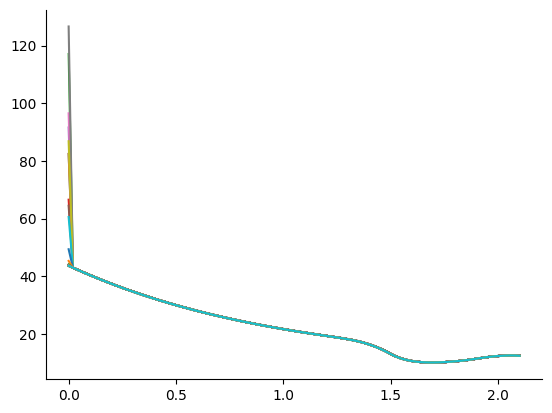

In [10]:
plt.plot(y1_grid_cap, ems)
plt.show()

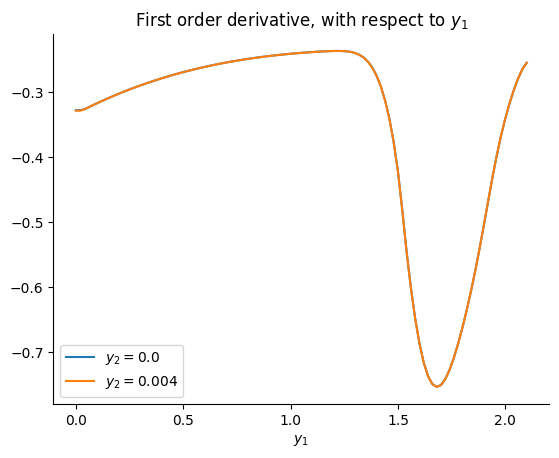

In [11]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

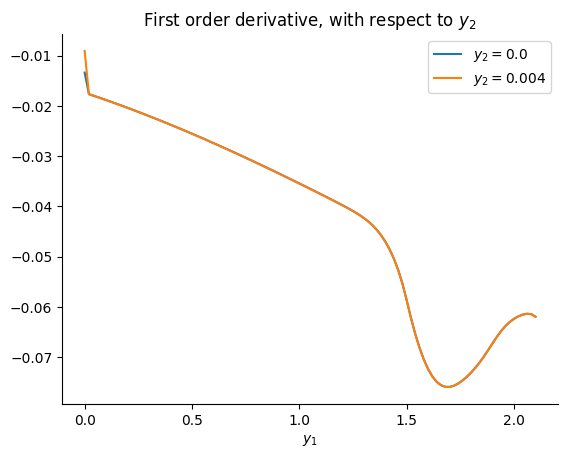

In [12]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

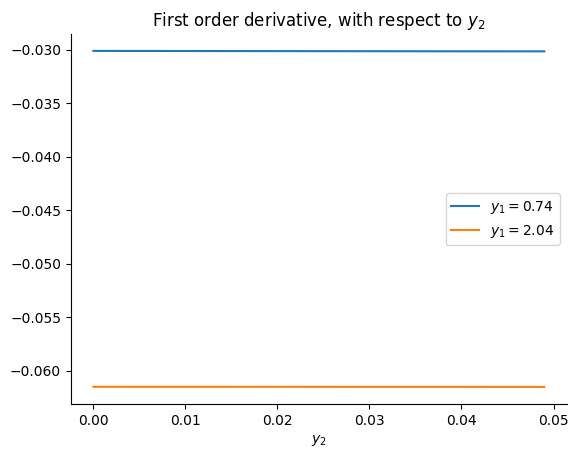

In [13]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

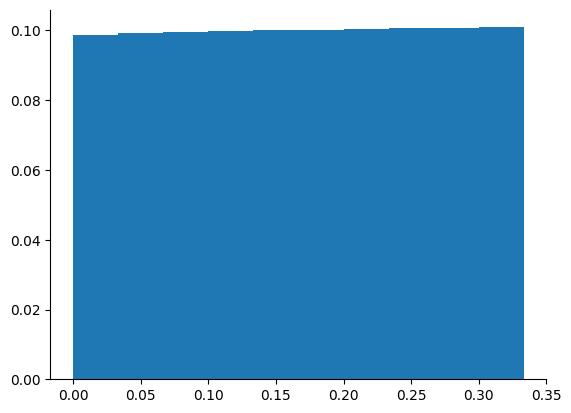

In [14]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

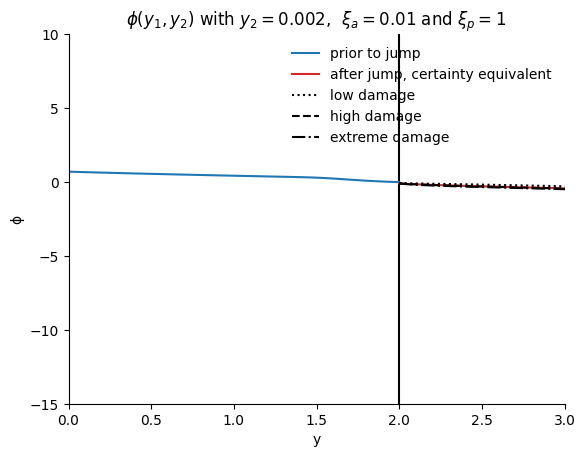

In [15]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

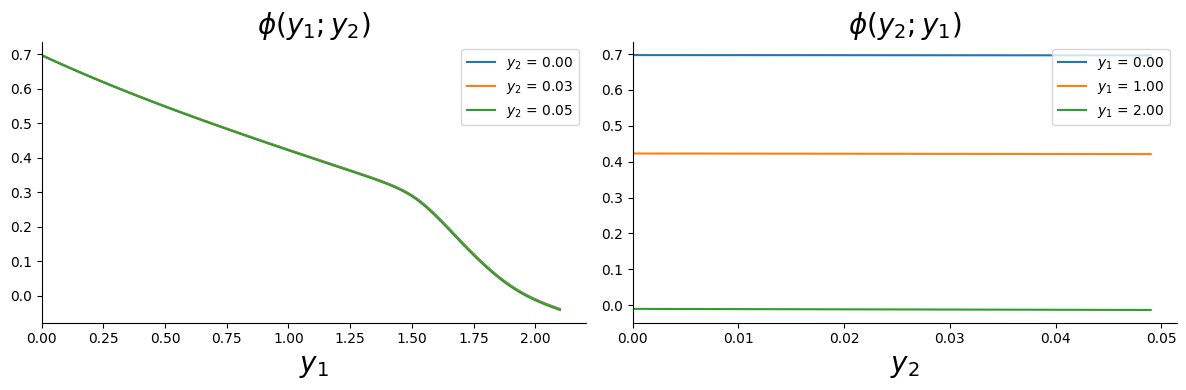

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

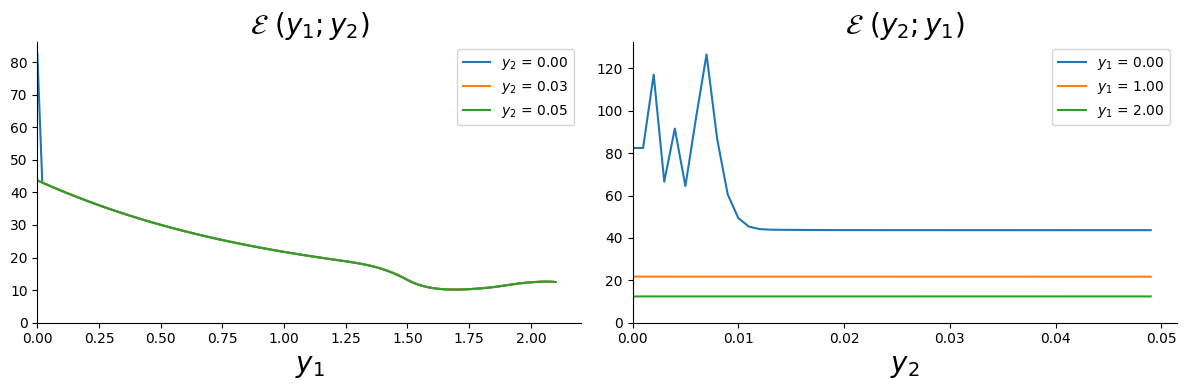

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [18]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [19]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [20]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [21]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [22]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

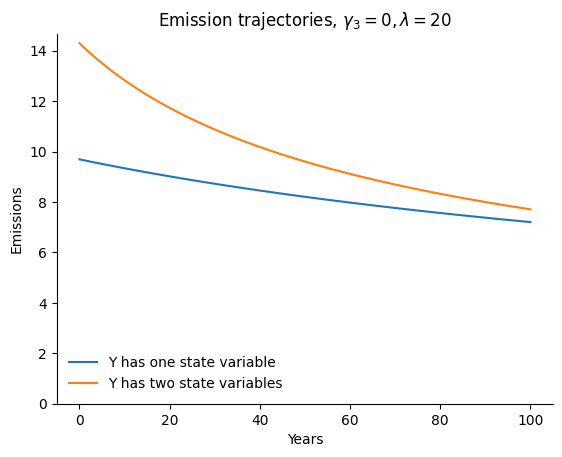

In [23]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [24]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=37
                                                 )

In [25]:
y1t_prejump

array([1.1       , 1.13822862, 1.17560341, 1.21220689, 1.24806722,
       1.28319027, 1.31754577, 1.35104747, 1.38353905, 1.41483093,
       1.44469515, 1.47292476, 1.49934141, 1.52385043, 1.54672169,
       1.56840157, 1.58920331, 1.60935795, 1.62904165, 1.64839283,
       1.66752298, 1.68652378, 1.70547163, 1.72443065, 1.7434548 ,
       1.76258963, 1.78187411, 1.80134314, 1.82103078, 1.84097409,
       1.86121643, 1.88180797, 1.90280027, 1.92423341, 1.94611976,
       1.96843445, 1.99112205, 2.01411436])

In [26]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open(f"simul_{λ}", "wb"))

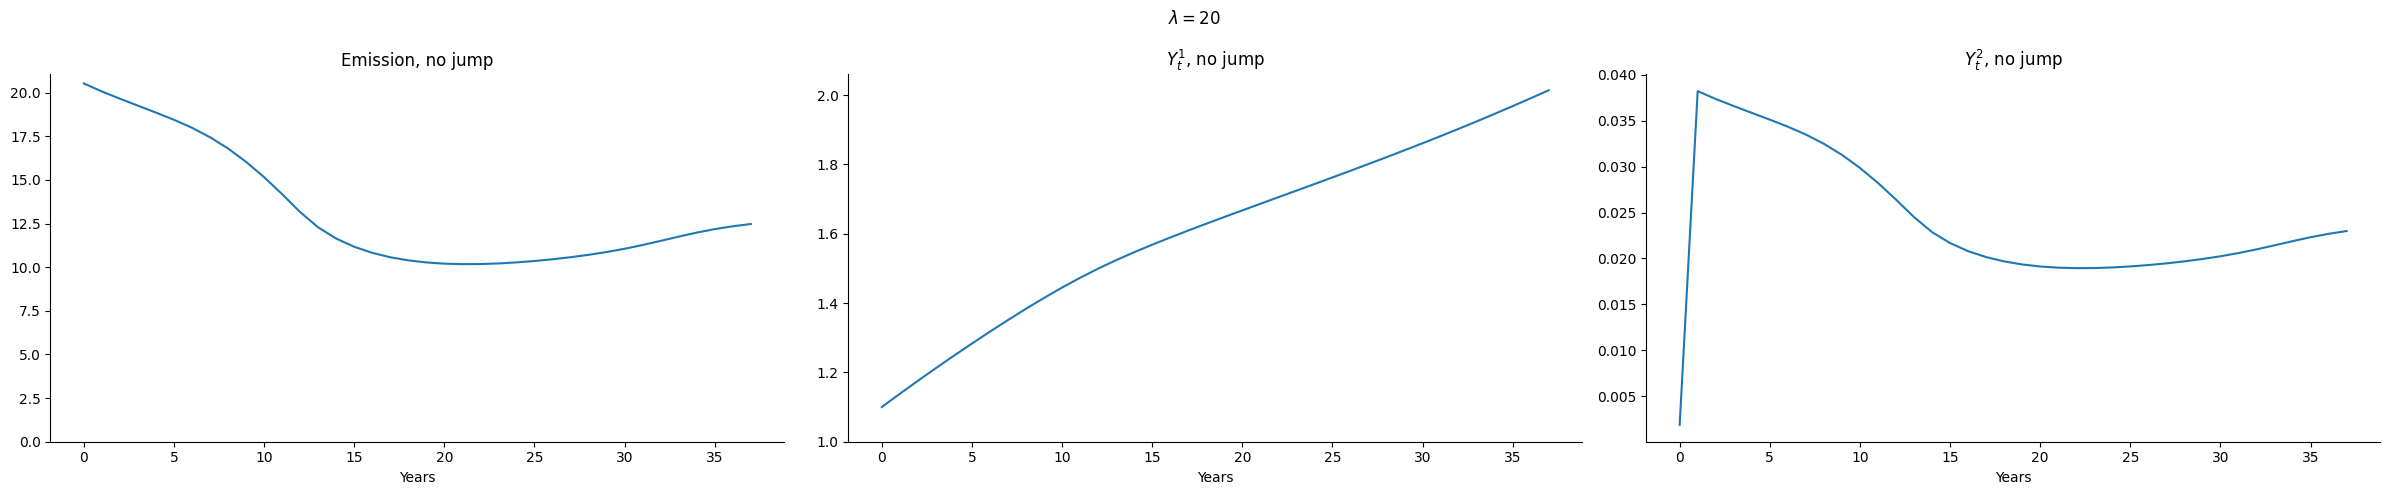

In [27]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$, no jump")
plt.plot(y2t_prejump)
# plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [28]:
y2t_prejump.max(), y2_grid[-1], y1t_prejump

(0.038228615697881885,
 0.049,
 array([1.1       , 1.13822862, 1.17560341, 1.21220689, 1.24806722,
        1.28319027, 1.31754577, 1.35104747, 1.38353905, 1.41483093,
        1.44469515, 1.47292476, 1.49934141, 1.52385043, 1.54672169,
        1.56840157, 1.58920331, 1.60935795, 1.62904165, 1.64839283,
        1.66752298, 1.68652378, 1.70547163, 1.72443065, 1.7434548 ,
        1.76258963, 1.78187411, 1.80134314, 1.82103078, 1.84097409,
        1.86121643, 1.88180797, 1.90280027, 1.92423341, 1.94611976,
        1.96843445, 1.99112205, 2.01411436]))

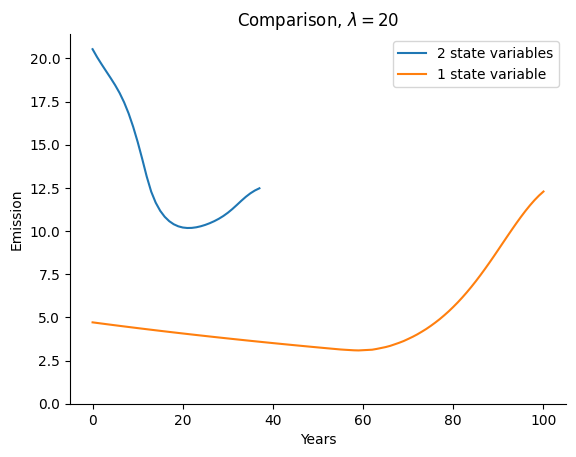

In [29]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [30]:

# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [31]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [32]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=90)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

ValueError: operands could not be broadcast together with shapes (90,) (38,) 

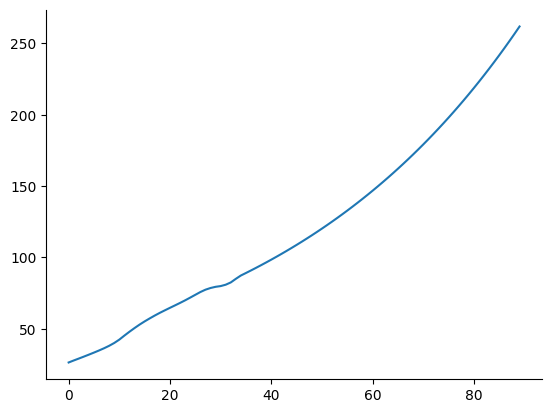

In [74]:
plt.plot(scc)
plt.show()

In [60]:
np.save(f"scct_{λ}", scc)